## OBL Dataset

In [3]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 356 µs (started: 2021-12-08 18:09:41 +00:00)


In [65]:
from openbiolink.obl2021 import OBL2021Dataset, OBL2021Evaluator
import torch
import pandas as pd
import numpy as np

dl = OBL2021Dataset()
ev = OBL2021Evaluator()

train = dl.training # torch.tensor of shape(num_train,3)
valid = dl.validation # torch.tensor of shape(num_val,3)

Dataset found in /Users/siqiwang/Documents/MSC/Project/Draft notebooks/obl2021, omitting download...
time: 4.93 s (started: 2021-12-08 21:14:55 +00:00)


In [171]:
# import pickle
# with open('obl2021/_dict_of_heads.pkl', 'rb') as f:
#     data = pickle.load(f)
print(dl.stats)

# Triples:     
     Train 4192002
     Valid 186301
     Test  180964
# Relations:   28
# Entities:    180992

time: 66.8 ms (started: 2021-12-09 15:15:45 +00:00)


In [172]:
# data distribution

train_df = pd.DataFrame(train.numpy())
train_df.columns = ['head', 'relation', 'tail']
train_df['relation'].value_counts()
# train_df

15    1322942
17     707539
24     315154
12     247380
11     232345
18     184184
14     163200
4      161453
22     145354
21     122434
20     120463
26     118235
25     116616
8       80406
10      24952
6       22844
1       21394
9       18227
27      14909
7       14859
2       11748
19       9134
0        6399
23       4142
13       2658
5        1842
3        1118
16         71
Name: relation, dtype: int64

time: 277 ms (started: 2021-12-09 15:15:52 +00:00)


In [173]:
valid_df = pd.DataFrame(valid.numpy())
valid_df.columns = ['head', 'relation', 'tail']
valid_df['relation'].value_counts()

15    64957
24    17566
17    14005
12    13725
11    12936
18     9695
4      7908
22     7538
21     6578
20     6343
25     6136
26     5261
8      4233
10     1323
14     1323
6      1180
1      1131
9       939
7       774
27      750
2       612
19      480
0       367
23      219
13      150
5       103
3        67
16        2
Name: relation, dtype: int64

time: 41.3 ms (started: 2021-12-09 15:15:55 +00:00)


In [174]:
# Set of unfiltered candidates that can substitute for ? in (h,r,?) and (?,r,t).
# just all the entities in the KG

dl.candidates

tensor([     0,      1,      2,  ..., 180989, 180990, 180991])

time: 59.6 ms (started: 2021-12-09 15:15:59 +00:00)


In [175]:
test_df = pd.DataFrame(dl.testing.numpy())
test_df.columns = ['head', 'relation', 'tail']
test_df['relation'].value_counts()

15    64846
24    19543
12    15082
11    14245
18    10217
4      8391
22     8098
20     6903
21     6782
25     6485
26     5414
8      4456
10     1398
6      1262
14     1200
1      1161
9       998
27      814
7       755
17      706
2       674
19      561
0       350
23      275
13      155
5       115
3        74
16        4
Name: relation, dtype: int64

time: 28.2 ms (started: 2021-12-09 15:16:02 +00:00)


## Embedding models

### Store embeddings

In [176]:
# TransE model
# embeddings of entities and relations

tse_entity_emb = torch.from_numpy(np.load("./ckpts/TransE_l2_OBL2021_3/OBL2021_TransE_l2_entity.npy"))
tse_relation_emb = torch.from_numpy(np.load("./ckpts/TransE_l2_OBL2021_3/OBL2021_TransE_l2_relation.npy"))

time: 199 ms (started: 2021-12-09 15:16:15 +00:00)


In [177]:
# DistMult model

dist_entity_emb = torch.from_numpy(np.load("./ckpts/DistMult_OBL2021_0/OBL2021_DistMult_entity.npy"))
dist_relation_emb = torch.from_numpy(np.load("./ckpts/DistMult_OBL2021_0/OBL2021_DistMult_relation.npy"))

time: 218 ms (started: 2021-12-09 15:16:16 +00:00)


In [178]:
# ComplEx model

cplx_entity_emb = torch.from_numpy(np.load("./ckpts/ComplEx_OBL2021_1/OBL2021_ComplEx_entity.npy"))
cplx_relation_emb = torch.from_numpy(np.load("./ckpts/ComplEx_OBL2021_1/OBL2021_ComplEx_relation.npy"))

time: 200 ms (started: 2021-12-09 15:16:17 +00:00)


### Define score functions for TransE, DistMult and ComplEx

In [179]:
# calculate the transE score for a triple

def transe_score(entity_emb, relation_emb, triple):
    score = entity_emb[triple[0]] + relation_emb[triple[1]] - entity_emb[triple[2]]
    return 8 - torch.norm(score, p=2, dim=-1).numpy()
transe_score(tse_entity_emb, tse_relation_emb, valid[1])

0.3289828300476074

time: 45.8 ms (started: 2021-12-09 15:16:21 +00:00)


In [180]:
# calculate the DistMult score for a triple

def distmult_score(entity_emb, relation_emb, triple):
    score = entity_emb[triple[0]] * relation_emb[triple[1]] * entity_emb[triple[2]]
    return torch.sum(score, dim=-1).numpy()
distmult_score(dist_entity_emb, dist_relation_emb, valid[1])

array(0.2825771, dtype=float32)

time: 29.7 ms (started: 2021-12-09 15:16:22 +00:00)


In [181]:
# calculate the ComplEx score for a triple

def complex_score(entity_emb, relation_emb, triple):
    real_head, img_head = torch.chunk(entity_emb[triple[0]], 2, dim=-1)
    real_tail, img_tail = torch.chunk(entity_emb[triple[2]], 2, dim=-1)
    real_rel, img_rel = torch.chunk(relation_emb[triple[1]], 2, dim=-1)

    score = real_head * real_tail * real_rel \
            + img_head * img_tail * real_rel \
            + real_head * img_tail * img_rel \
            - img_head * real_tail * img_rel
    return torch.sum(score, -1).numpy()
complex_score(cplx_entity_emb, cplx_relation_emb, valid[1])

array(0.6582771, dtype=float32)

time: 12.2 ms (started: 2021-12-09 15:16:25 +00:00)


### Generate and analyse predictions

In [193]:
# modified from https://github.com/nomisto/openbiolink-2021-embedding-baseline/blob/main/save_test_submission.py

import os
from dglke.train_pytorch import load_model_from_checkpoint
from dglke.utils import load_model_config
from tqdm import tqdm

# ckpt_path = "./ckpts/DistMult_OBL2021_0"
# ckpt_path = "./ckpts/TransE_l2_OBL2021_3"
ckpt_path = "./ckpts/ComplEx_OBL2021_1"
config = load_model_config(os.path.join(ckpt_path, 'config.json'))
class Args:
    model_path = ckpt_path
    batch_size_eval = 100
    gpu = [-1]
args = Args()
args.model_name = config["model"]
args.hidden_dim = config["emb_size"]
args.gamma = config["gamma"]
args.double_ent = config["double_ent"]
args.double_rel = config["double_rel"]
args.dataset = config["dataset"]
args.train = False
args.valid = False
args.test = True
args.strict_rel_part = False
args.soft_rel_part = False
args.async_update = False
args.has_edge_importance = False
args.mix_cpu_gpu = False
gpu_id = args.gpu[0]

# ev = OBL2021Evaluator()
# dl = OBL2021Dataset("./data/OBL2021")
n_entities = dl.num_entities
n_relations = dl.num_relations

model = load_model_from_checkpoint(args, n_entities, n_relations, ckpt_path)

head_neg_score = model.score_func.create_neg(True)
tail_neg_score = model.score_func.create_neg(False)
head_neg_prepare = model.score_func.create_neg_prepare(True)
tail_neg_prepare = model.score_func.create_neg_prepare(False)

entity_emb = model.entity_emb(torch.arange(dl.num_entities).long(), gpu_id)
relation_emb = model.relation_emb(torch.arange(dl.num_relations).long(), gpu_id)

n_batches, batches = dl.get_test_batches(args.batch_size_eval)

top10_tails = []
top10_heads = []
logs_h = []
logs_t = []

for batch in tqdm(batches, total=n_batches):
    
    pos_head_emb = entity_emb[batch[:, 0], :]
    pos_tail_emb = entity_emb[batch[:, 2], :]
    pos_rel = batch[:, 1].long()
    pos_rel_emb = relation_emb[pos_rel, :]

    neg_head, tail = head_neg_prepare(pos_rel, 1, entity_emb, pos_tail_emb, gpu_id, False)
    scores_head = head_neg_score(neg_head, pos_rel_emb, tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    head, neg_tail = tail_neg_prepare(pos_rel, 1, pos_head_emb, entity_emb, gpu_id, False)
    scores_tail = tail_neg_score(head, pos_rel_emb, neg_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    
    pos_score = torch.diagonal(tail_neg_score(pos_head_emb, pos_rel_emb, pos_tail_emb,
                                    1, len(batch), len(batch)).squeeze(0), 0).reshape(len(batch),1)
    
    scores_head = dl.filter_scores(
        batch,
        scores_head,
        0,
        float('-Inf')
    )
    scores_tail = dl.filter_scores(
        batch,
        scores_tail,
        2,
        float('-Inf')
    )

    rankings_h = torch.sum(scores_head > pos_score, dim=1) + 1
    rankings_h = rankings_h.numpy()
    rankings_t = torch.sum(scores_tail > pos_score, dim=1) + 1
    rankings_t = rankings_t.numpy()

    for i in range(len(batch)):
        ranking_h = rankings_h[i]
        ranking_t = rankings_t[i]
        logs_h.append({
            'MRR': 1.0 / ranking_h,
            'MR': float(ranking_h),
            # 'HITS@1': 1.0 if ranking_h <= 1 else 0.0,
            # 'HITS@3': 1.0 if ranking_h <= 3 else 0.0,
            # 'HITS@10': 1.0 if ranking_h <= 10 else 0.0
        })
        logs_t.append({
            'MRR': 1.0 / ranking_t,
            'MR': float(ranking_t),
            # 'HITS@1': 1.0 if ranking_t <= 1 else 0.0,
            # 'HITS@3': 1.0 if ranking_t <= 3 else 0.0,
            # 'HITS@10': 1.0 if ranking_t <= 10 else 0.0
        })    

    top10_heads.append(torch.topk(scores_head, 10)[1])
    top10_tails.append(torch.topk(scores_tail, 10)[1])

top10_heads = torch.cat(top10_heads, dim=0)
top10_tails = torch.cat(top10_tails, dim=0)

ev.eval(top10_heads, top10_tails, dl.testing)

./ckpts/ComplEx_OBL2021_1/config.json
{'dataset': 'OBL2021', 'model': 'ComplEx', 'emb_size': 380, 'max_train_step': 800000, 'batch_size': 1024, 'neg_sample_size': 512, 'lr': 0.1, 'gamma': 12.0, 'double_ent': False, 'double_rel': False, 'neg_adversarial_sampling': True, 'adversarial_temperature': 1.0, 'regularization_coef': 2e-06, 'regularization_norm': 3, 'emap_file': 'entities.tsv', 'rmap_file': 'relations.tsv'}


100%|███████████████████████████████████████| 1810/1810 [16:31<00:00,  1.83it/s]


Submission file saved here: /Users/siqiwang/Documents/MSC/Project/Draft notebooks/pred_OBL2021.npz
Please copy also the following line in the respective field of the submission form:
{'h10': 0.5087254643440247}
time: 16min 33s (started: 2021-12-08 10:45:22 +00:00)


In [197]:
metrics_h = {}
metrics_t = {}
metrics = {}
for metric in logs_h[0].keys():
    metrics_h[metric] = sum([log[metric] for log in logs_h]) / len(logs_h)
print("-------------- Test result for head --------------")
for k, v in metrics_h.items():
    print('Test average for head {}: {}'.format(k, v))
print("-----------------------------------------")

for metric in logs_t[0].keys():
    metrics_t[metric] = sum([log[metric] for log in logs_t]) / len(logs_t)
print("-------------- Test result for tail --------------")
for k, v in metrics_t.items():
    print('Test average for tail {}: {}'.format(k, v))
print("-----------------------------------------")

for metric in logs_h[0].keys():
    metrics[metric] = (sum([log[metric] for log in logs_h]) + sum([log[metric] for log in logs_t])) / (2 * len(logs_h))
print("-------------- Test result --------------")
for k, v in metrics.items():
    print('Test average {}: {}'.format(k, v))
print("-----------------------------------------")

-------------- Test result for head --------------
Test average for head MRR: 0.13007238641250454
Test average for head MR: 892.6067670917972
Test average for head HITS@1: 0.041953095643332376
Test average for head HITS@3: 0.14317212263212573
Test average for head HITS@10: 0.32115779934130545
-----------------------------------------
-------------- Test result for tail --------------
Test average for tail MRR: 0.3504361650766187
Test average for tail MR: 572.3487268185937
Test average for tail HITS@1: 0.20189650980305476
Test average for tail HITS@3: 0.40570500209986515
Test average for tail HITS@10: 0.6881092371963484
-----------------------------------------
-------------- Test result --------------
Test average MRR: 0.2402542757445616
Test average MR: 732.4777469551955
Test average HITS@1: 0.12192480272319356
Test average HITS@3: 0.27443856236599545
Test average HITS@10: 0.504633518268827
-----------------------------------------
time: 301 ms (started: 2021-12-08 11:05:46 +00:00)


In [56]:
# try to analyse the predictions made by TransE, DistMult, ComplEx and AnyBURL
# assume: (h, r, ?) then (?, r, t)

transe_pred = np.load("./pred/pred_OBL2021_transe.npz")
transe_pred = transe_pred["pred_top10"]
transe_pred

array([[167833, 168666, 171063, ..., 167793, 168680, 168420],
       [168819, 169140, 171063, ..., 173717, 169235, 167935],
       [ 77274,  75218,  82786, ...,  83390,  74060,  72368],
       ...,
       [  2592,   2418,   6982, ...,   8206,   2503,   5569],
       [ 76393,  75273,  86351, ...,  85010,  85950,  81428],
       [ 78513,  78815,  84972, ...,  88182,  89411,  77549]], dtype=int32)

time: 117 ms (started: 2021-12-08 21:09:51 +00:00)


In [57]:
dist_pred = np.load("./pred/pred_OBL2021_dist.npz")
dist_pred = dist_pred["pred_top10"]
dist_pred

array([[168666, 167833, 167590, ..., 169156, 168813, 167759],
       [168819, 168031, 167451, ..., 169140, 168896, 172605],
       [ 77274,  73401,  86899, ...,  77585,  83239,  75218],
       ...,
       [  2595,   2592, 168888, ...,   4429,   8852,   2291],
       [ 86351,  81145,  84825, ...,  77329,  85011,  85950],
       [ 78513,  74539,  76125, ...,  83441,  70799,  88707]], dtype=int32)

time: 104 ms (started: 2021-12-08 21:09:57 +00:00)


In [58]:
cplx_pred = np.load("./pred/pred_OBL2021_cplx2.npz")
cplx_pred = cplx_pred["pred_top10"]
cplx_pred

array([[167833, 168666,     18, ..., 168269, 176376, 168426],
       [168819,     18, 169235, ..., 167935, 168863, 169156],
       [ 77274,  73439,  83390, ...,  77585,  89366,  75049],
       ...,
       [167833,   4087, 171597, ...,   2509,  24370,   4576],
       [ 76393,  86351,  84825, ...,  85011,  81014,  85010],
       [ 78513,  70231,  72804, ...,  85896,  77549,  86533]], dtype=int32)

time: 101 ms (started: 2021-12-08 21:09:59 +00:00)


In [59]:
any_pred = np.load("./pred/pred_OBL2021_anyburl.npz")
any_pred = any_pred["pred_top10"]
any_pred

array([[167833, 168666, 168677, ..., 169745, 172605, 172329],
       [169140, 168819, 168889, ..., 167451, 168863, 168896],
       [ 70480,  72013,  72133, ...,  75011,  84912,  74873],
       ...,
       [  4510,   4804,   3391, ...,   4833,   4840,   4825],
       [ 81145,  81428,  87494, ...,  81014,  81978,  81987],
       [ 86533,  71520,  78815, ...,  83566,  71915,  71988]], dtype=int32)

time: 104 ms (started: 2021-12-08 21:10:01 +00:00)


In [93]:
# predictions for (h, r, ?)

dist_pred[:dl.testing.shape[0], :]

array([[168666, 167833, 167590, ..., 169156, 168813, 167759],
       [168819, 168031, 167451, ..., 169140, 168896, 172605],
       [ 77274,  73401,  86899, ...,  77585,  83239,  75218],
       ...,
       [  7926, 171459,   7925, ...,   7084, 167817, 167462],
       [ 86559,  76393,  70602, ...,  75273,  74990,  85011],
       [165936,  69822,  69859, ...,  69959,  69946, 165763]], dtype=int32)

In [ ]:
# predictions for (?, r, t)

dist_pred[dl.testing.shape[0]:, :]

## Rule-based model: AnyBURL

In [2]:
# rules generated by AnyBURL, in the format of:
# {predicted: int}\t{correctlyPredicted: int}\t{confidence: double}\t{rule}
rule_file_path = "./rules-1000"

with open(rule_file_path) as infile:
    rules = infile.readlines()
rules = [x.strip() for x in rules]
rules = [x.split("\t") for x in rules]

# transform rules (list) to a DataFrame
rules_df = pd.DataFrame(rules)
rules_df.columns = ["predicted", "correct_pred", "conf", "tbc"]
rules_df["conf"] = rules_df["conf"].apply(lambda x: float(x))

# separate head atom and body atoms of the rules
rules_df["head_atom_relation"] = rules_df["tbc"].apply(lambda x: x.split("(")[0])
rules_df["head_atom_head"] = rules_df["tbc"].apply(lambda x: x.split("(")[1].split(",")[0])
rules_df["head_atom_tail"] = rules_df["tbc"].apply(lambda x: x.split(")")[0].split(",")[1])
rules_df["body_atom"] = rules_df["tbc"].apply(lambda x: x.split("= ")[1])
# record the length of body atoms
rules_df["body_len"] = rules_df["body_atom"].apply(lambda x: len(x.split(", ")))
rules_df.drop(columns="tbc",inplace=True)

In [16]:
# rules_df[((rules_df["head_atom_head"] != "X") | (rules_df["head_atom_tail"] != "Y")) & (rules_df["contain_A"] == True)]
# rules_df
# rules_df["contain_A"] = rules_df["body_atom"].apply(lambda x: "A" in x)
rules_df["head_atom_relation"].value_counts()

17    187288
15    122399
24    100768
11     97784
12     81205
14     26320
4      24870
20     20131
25     16449
18     15945
22     14196
10     13456
21     12600
6       8066
8       7702
19      7046
7       4894
9       4700
2       3703
23      3359
26      1712
1       1325
5        966
3        617
0        517
13       144
27        98
16         9
Name: head_atom_relation, dtype: int64

In [17]:
# store training data in a list
training_list = dl.training.tolist()

# transform training list to the form of r(h, t) for later use
# i.e. [86169, 22, 61677] -> "22(86169,61677)"
trans_training_list = [str(t[1]) + "(" + str(t[0]) + "," + str(t[2]) + ")" for t in training_list]

### Define the score function for AnyBURL

In [18]:
# calculate the anyBURL score for a triple
# rules: transformed dataframe of the rules file, triple: tensor(h, r, t) that does not exist in training set
def anyBURL_score(rules, triple):
    # filter the rules with head atom == r(h, Y), r(X, t) and r(X, Y)
    filtered = rules[rules["head_atom_relation"] == str(triple[1].numpy())]
    filtered = filtered[(filtered["head_atom_head"] == str(triple[0].numpy())) | (filtered["head_atom_tail"] == str(triple[2].numpy())) | ((filtered["head_atom_head"] == "X") & (filtered["head_atom_tail"] == "Y"))]

    # replace X with head and Y with tail
    filtered["body_atom"] = filtered["body_atom"].apply(lambda x: x.replace("X", str(triple[0].numpy())))
    filtered["body_atom"] = filtered["body_atom"].apply(lambda x: x.replace("Y", str(triple[2].numpy())))

    idx = []
    # iterate through rows of filtered rules to see if their body atoms fulfill conditions
    for index1, row1 in filtered.iterrows():
        # body atoms do not contain A or B
        if "A" not in row1["body_atom"]:
            if row1["body_atom"] in trans_training_list: idx.append(index1)

        else:
            # set an indicator to see if body atoms are possibly generated by training set
            fulfilled = False
            # create a new dataframe to store the body atoms
            ba_df = pd.DataFrame(row1["body_atom"].split(", "), columns=["tbc"])
            ba_df["relation"] = ba_df["tbc"].apply(lambda x: x.split("(")[0])
            ba_df["head"] = ba_df["tbc"].apply(lambda x: x.split("(")[1].split(",")[0])
            ba_df["tail"] = ba_df["tbc"].apply(lambda x: x.split(")")[0].split(",")[1])
            ba_df.drop(columns="tbc", inplace=True)
            # body atoms contain only A
            if "B" not in row1["body_atom"]:
                # add an empty column to store the possible value of A
                ba_df["possible_A"] = ""
                for index2, row2 in ba_df.iterrows():
                    if row2["tail"] == "A":
                        row2["possible_A"] = train_df[(train_df["head"] == int(row2["head"])) & (train_df["relation"] == int(row2["relation"]))]["tail"].tolist()
                    elif row2["head"] == "A":
                        row2["possible_A"] = train_df[(train_df["tail"] == int(row2["tail"])) & (train_df["relation"] == int(row2["relation"]))]["head"].tolist()
                if ba_df.count()["relation"] > 1:
                    # check if two lists contain common element
                    fulfilled = not set(ba_df.iloc[0]["possible_A"]).isdisjoint(ba_df.iloc[1]["possible_A"])
                else:
                    # check if any element in possible_A
                    fulfilled = not ba_df.iloc[0]["possible_A"] == ""

            # body atoms contain A and B
            else:
            # add empty columns to store the possible value of A and B
                ba_df["possible_A"] = ""
                ba_df["possible_B"] = ""
                for index3, row3 in ba_df.iterrows():
                    # r(A, B)
                    if row3["head"] == "A" and row3["tail"] == "B":
                        row3["possible_A"] = train_df[train_df["relation"] == int(row3["relation"])]["head"].tolist()
                        row3["possible_B"] = train_df[train_df["relation"] == int(row3["relation"])]["tail"].tolist()
                    # r(B, A)
                    elif row3["head"] == "B" and row3["tail"] == "A":
                        row3["possible_A"] = train_df[train_df["relation"] == int(row3["relation"])]["tail"].tolist()
                        row3["possible_B"] = train_df[train_df["relation"] == int(row3["relation"])]["head"].tolist()
                    # r(A, X)
                    elif row3["head"] == "A":
                        row3["possible_A"] = train_df[(train_df["tail"] == int(row3["tail"])) & (train_df["relation"] == int(row3["relation"]))]["head"].tolist()
                    # r(X, A)
                    elif row3["tail"] == "A":
                        row3["possible_A"] = train_df[(train_df["head"] == int(row3["head"])) & (train_df["relation"] == int(row3["relation"]))]["tail"].tolist()
                    # r(B, Y)
                    elif row3["head"] == "B":
                        row3["possible_B"] = train_df[(train_df["tail"] == int(row3["tail"])) & (train_df["relation"] == int(row3["relation"]))]["head"].tolist()
                    # r(Y, B)
                    elif row3["tail"] == "B":
                        row3["possible_B"] = train_df[(train_df["head"] == int(row3["head"])) & (train_df["relation"] == int(row3["relation"]))]["tail"].tolist()
                # check if lists of A and lists of B contain common element at the same time
                fulfilled = (not set(ba_df.iloc[0]["possible_A"]).isdisjoint(ba_df.iloc[1]["possible_A"])) & (not set(ba_df.iloc[1]["possible_B"]).isdisjoint(ba_df.iloc[2]["possible_B"]))
            if fulfilled == True: idx.append(index1)
    if len(idx) < 1:
        score = 0
    else: 
        # retrieve the max confidence
        max_row = rules.loc[idx[np.argmax(rules.loc[idx]["conf"].tolist())]]
        # calculate the score for this triple
        score = int(max_row["correct_pred"]) / (int(max_row["predicted"]) + 5)
    return score


In [19]:
train_df[(train_df["head"] == 72318) & (train_df["relation"] == 15) & (train_df["tail"] == 169243)]

,head,relation,tail
3690606,72318,15,169243


## Hybrid model

### Logistic regression - combine 2 embedding models

In [131]:
# prepare the training data for hybrid model:
# combine training and valid data

train_plus = torch.cat([train, valid], dim=0)
train_plus.shape

torch.Size([4378303, 3])

time: 166 ms (started: 2021-12-08 22:36:14 +00:00)


In [132]:
# modified based on pykeen.sampling.basic_negative_sampler
import math

def negative_sample(positive_triples):
    LOOKUP = {"h": 0, "r": 1, "t": 2}

    # Bind number of negatives to sample
    num_negs = positive_triples.shape[0]
    
    # Equally corrupt all sides
    corruption_indices = [LOOKUP[side] for side in ("h", "t")]
    split_idx = int(math.ceil(num_negs / len(corruption_indices)))

    # Copy positive batch for corruption.
    negative_batch = positive_triples.clone()

    for index, start in zip(corruption_indices, range(0, num_negs, split_idx)):
        stop = min(start + split_idx, num_negs)

        # Relations have a different index maximum than entities
        # At least make sure to not replace the triples by the original value
        index_max = (dl.num_relations if index == 1 else dl.num_entities) - 1

        negative_batch[start:stop, index] = torch.randint(
            high=index_max,
            size=(stop - start,),
        )

        # To make sure we don't replace the {head, relation, tail} by the
        # original value we shift all values greater or equal than the original value by one up
        # for that reason we choose the random value from [0, num_{heads, relations, tails} -1]
        negative_batch[start:stop, index] += (
            negative_batch[start:stop, index] >= positive_triples[start:stop, index]
        ).long()

    return negative_batch

time: 1.7 ms (started: 2021-12-08 22:36:19 +00:00)


In [133]:
neg = negative_sample(train_plus)

time: 108 ms (started: 2021-12-08 22:36:20 +00:00)


In [141]:
# store the scores for each model of all positive triples

pos_df = pd.DataFrame(columns=["triple", "complEx_score", "transE_score", "distMult_score", "Y"])
pos_df["triple"] = [train_plus[n] for n in range(train_plus.shape[0])]
pos_df["relation"] = pos_df["triple"].apply(lambda x: x[1].numpy())
pos_df["complEx_score"] = pos_df["triple"].apply(lambda x: complex_score(cplx_entity_emb, cplx_relation_emb, x))
pos_df["transE_score"] = pos_df["triple"].apply(lambda x: transe_score(tse_entity_emb, tse_relation_emb, x))
pos_df["distMult_score"] = pos_df["triple"].apply(lambda x: distmult_score(dist_entity_emb, dist_relation_emb, x))
pos_df["Y"] = 1
pos_df

,triple,complEx_score,transE_score,distMult_score,Y,relation
0,"[tensor(71575), tensor(22), tensor(61677)]",2.434209,1.218738,2.752507,1,22
1,"[tensor(76374), tensor(15), tensor(167503)]",1.205381,0.199618,0.753454,1,15
2,"[tensor(81297), tensor(15), tensor(167724)]",1.144615,0.533805,0.763239,1,15
3,"[tensor(74447), tensor(11), tensor(81239)]",0.746615,-0.134726,1.314600,1,11
4,"[tensor(80732), tensor(25), tensor(600)]",0.911771,0.941666,1.103542,1,25
...,...,...,...,...,...,...
4378298,"[tensor(75694), tensor(11), tensor(76015)]",1.814968,1.713939,1.607447,1,11
4378299,"[tensor(76954), tensor(12), tensor(76091)]",1.510505,0.265041,1.280309,1,12
4378300,"[tensor(86473), tensor(22), tensor(57142)]",1.854097,1.352559,0.984690,1,22
4378301,"[tensor(88252), tensor(18), tensor(54419)]",-2.420667,-2.087488,-3.611161,1,18


time: 9min 48s (started: 2021-12-08 22:41:00 +00:00)


In [142]:
# store the scores for each model of all negative triples

neg_df = pd.DataFrame(columns=["triple", "complEx_score", "transE_score", "distMult_score", "Y"])
neg_df["triple"] = [neg[n] for n in range(neg.shape[0])]
neg_df["relation"] = neg_df["triple"].apply(lambda x: x[1].numpy())
neg_df["complEx_score"] = neg_df["triple"].apply(lambda x: complex_score(cplx_entity_emb, cplx_relation_emb, x))
neg_df["transE_score"] = neg_df["triple"].apply(lambda x: transe_score(tse_entity_emb, tse_relation_emb, x))
neg_df["distMult_score"] = neg_df["triple"].apply(lambda x: distmult_score(dist_entity_emb, dist_relation_emb, x))
neg_df["Y"] = -1

time: 9min 53s (started: 2021-12-08 22:50:49 +00:00)


In [144]:
# combine positive and negative triples for training

emb_df = pd.concat([pos_df, neg_df], ignore_index=True)
emb_df.drop(columns=["triple", "relation"], inplace=True)
emb_df

,complEx_score,transE_score,distMult_score,Y
0,2.434209,1.218738,2.752507,1
1,1.205381,0.199618,0.753454,1
2,1.144615,0.533805,0.763239,1
3,0.746615,-0.134726,1.314600,1
4,0.911771,0.941666,1.103542,1
...,...,...,...,...
8756601,-4.282713,-6.837650,-4.790776,-1
8756602,-4.260866,-3.189675,-4.185231,-1
8756603,-3.360731,-3.919358,-5.090248,-1
8756604,-3.903957,-6.971076,-4.531449,-1


time: 6.49 s (started: 2021-12-09 00:23:24 +00:00)


In [145]:
# preprocess the data, dealing with different scales

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# emb_df[["transE_score", "distMult_score"]] = scaler.fit_transform(emb_df[["transE_score", "distMult_score"]])
emb_df[["complEx_score", "distMult_score"]] = scaler.fit_transform(emb_df[["complEx_score", "distMult_score"]])
emb_df

,complEx_score,transE_score,distMult_score,Y
0,0.791016,1.218738,0.834610,1
1,0.703045,0.199618,0.706275,1
2,0.698695,0.533805,0.706903,1
3,0.670202,-0.134726,0.742300,1
4,0.682026,0.941666,0.728750,1
...,...,...,...,...
8756601,0.310156,-6.837650,0.350347,-1
8756602,0.311720,-3.189675,0.389222,-1
8756603,0.376160,-3.919358,0.331122,-1
8756604,0.337271,-6.971076,0.366995,-1


time: 2.59 s (started: 2021-12-09 00:23:53 +00:00)


In [146]:
# train the logistic model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# X_train, X_test, y_train, y_test = train_test_split(emb_df.drop(["Y", "complEx_score"],axis=1), 
#                                                     emb_df["Y"], test_size=0.10, 
#                                                     random_state=101)

X_train, X_test, y_train, y_test = train_test_split(emb_df.drop(["Y", "transE_score"],axis=1), 
                                                    emb_df["Y"], test_size=0.10, 
                                                    random_state=101)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

time: 11.8 s (started: 2021-12-09 00:24:09 +00:00)


In [147]:
# produce the hybrid scores
# logmodel.decision_function(X_test)
X_test

,complEx_score,distMult_score
5516277,0.285022,0.294328
5273322,0.322696,0.350620
1506435,0.780080,0.879573
2298442,0.672605,0.721947
5900028,0.334109,0.335619
...,...,...
8654232,0.316963,0.351820
316133,0.726320,0.744672
1035168,0.821492,0.871429
6036159,0.312081,0.333388


time: 11.5 ms (started: 2021-12-09 00:24:23 +00:00)


### Evaluate and generate predictions

In [153]:
import os
from dglke.train_pytorch import load_model_from_checkpoint
from dglke.utils import load_model_config
from tqdm import tqdm

class Args():
    batch_size_eval = 100
    gpu = [-1]
    train = False
    valid = False
    test = True
    strict_rel_part = False
    soft_rel_part = False
    async_update = False
    has_edge_importance = False
    mix_cpu_gpu = False

def model_args(config):
    args = Args()
    args.model_name = config["model"]
    args.hidden_dim = config["emb_size"]
    args.gamma = config["gamma"]
    args.double_ent = config["double_ent"]
    args.double_rel = config["double_rel"]
    args.dataset = config["dataset"]
    return args
    
n_entities = dl.num_entities
n_relations = dl.num_relations

# import embeddings from the first model
te_ckpt_path = "./ckpts/TransE_l2_OBL2021_3"
# te_ckpt_path = "./ckpts/ComplEx_OBL2021_1"
te_config = load_model_config(os.path.join(te_ckpt_path, 'config.json'))
te_args = model_args(te_config)
te_model = load_model_from_checkpoint(te_args, n_entities, n_relations, te_ckpt_path)
gpu_id = te_args.gpu[0]

# some score functions
te_head_neg_score = te_model.score_func.create_neg(True)
te_tail_neg_score = te_model.score_func.create_neg(False)
te_head_neg_prepare = te_model.score_func.create_neg_prepare(True)
te_tail_neg_prepare = te_model.score_func.create_neg_prepare(False)

# the embeddings of entities and relations
te_entity_emb = te_model.entity_emb(torch.arange(dl.num_entities).long(), gpu_id)
te_relation_emb = te_model.relation_emb(torch.arange(dl.num_relations).long(), gpu_id)

# import embeddings from the second model
dm_ckpt_path = "./ckpts/DistMult_OBL2021_0"
dm_config = load_model_config(os.path.join(dm_ckpt_path, 'config.json'))
dm_args = model_args(dm_config)
dm_model = load_model_from_checkpoint(dm_args, n_entities, n_relations, dm_ckpt_path)

dm_head_neg_score = dm_model.score_func.create_neg(True)
dm_tail_neg_score = dm_model.score_func.create_neg(False)
dm_head_neg_prepare = dm_model.score_func.create_neg_prepare(True)
dm_tail_neg_prepare = dm_model.score_func.create_neg_prepare(False)

# the embeddings of entities and relations
dm_entity_emb = dm_model.entity_emb(torch.arange(dl.num_entities).long(), gpu_id)
dm_relation_emb = dm_model.relation_emb(torch.arange(dl.num_relations).long(), gpu_id)

# slice test set into batches of 100 triples each
n_batches, batches = dl.get_test_batches(te_args.batch_size_eval)

# lists to store the results of top10 predictions
top10_tails = []
top10_heads = []
logs_h = []
logs_t = []

for batch in tqdm(batches, total=n_batches):
    
    # head, tail, relation embeddings of test batch
    te_pos_head_emb = te_entity_emb[batch[:, 0], :]
    te_pos_tail_emb = te_entity_emb[batch[:, 2], :]
    pos_rel = batch[:, 1].long()
    te_pos_rel_emb = te_relation_emb[pos_rel, :]

    # neg_head: all entities, tail: pos_tail_emb
    te_neg_head, te_tail = te_head_neg_prepare(pos_rel, 1, te_entity_emb, te_pos_tail_emb, gpu_id, False)
    # scores in shape (100, num_entities)
    te_scores_head = te_head_neg_score(te_neg_head, te_pos_rel_emb, te_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    te_head, te_neg_tail = te_tail_neg_prepare(pos_rel, 1, te_pos_head_emb, te_entity_emb, gpu_id, False)
    te_scores_tail = te_tail_neg_score(te_head, te_pos_rel_emb, te_neg_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)

    # head, tail, relation embeddings of test batch
    dm_pos_head_emb = dm_entity_emb[batch[:, 0], :]
    dm_pos_tail_emb = dm_entity_emb[batch[:, 2], :]
    dm_pos_rel_emb = dm_relation_emb[pos_rel, :]

    # neg_head: all entities, tail: pos_tail_emb
    dm_neg_head, dm_tail = dm_head_neg_prepare(pos_rel, 1, dm_entity_emb, dm_pos_tail_emb, gpu_id, False)
    # scores in shape (100, num_entities)
    dm_scores_head = dm_head_neg_score(dm_neg_head, dm_pos_rel_emb, dm_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    dm_head, dm_neg_tail = dm_tail_neg_prepare(pos_rel, 1, dm_pos_head_emb, dm_entity_emb, gpu_id, False)
    dm_scores_tail = dm_tail_neg_score(dm_head, dm_pos_rel_emb, dm_neg_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
  
    # combine the scores together first, then calculate hybrid scores
    # (len(batch), n_entities, 3) -> (len(batch) * n_entities, 2)    
    cmb_head_scores = torch.cat([te_scores_head.reshape(len(batch), n_entities, 1), 
                                 dm_scores_head.reshape(len(batch), n_entities, 1)], dim=2).reshape(len(batch)*n_entities, 2)
    scores_head = logmodel.decision_function(scaler.transform(cmb_head_scores.detach().numpy()))
    cmb_tail_scores = torch.cat([te_scores_tail.reshape(len(batch), n_entities, 1), 
                                 dm_scores_tail.reshape(len(batch), n_entities, 1)], dim=2).reshape(len(batch)*n_entities, 2)
    scores_tail = logmodel.decision_function(scaler.transform(cmb_tail_scores.detach().numpy()))

    # (len(batch) * n_entities, 1) -> (len(batch), n_entities)
    scores_head = torch.FloatTensor(scores_head.reshape(len(batch), n_entities))
    scores_tail = torch.FloatTensor(scores_tail.reshape(len(batch), n_entities))
    
    te_pos_score = torch.diagonal(te_tail_neg_score(te_pos_head_emb, te_pos_rel_emb, te_pos_tail_emb,
                                1, len(batch), len(batch)).squeeze(0), 0).reshape(len(batch),1)   
    dm_pos_score = torch.diagonal(dm_tail_neg_score(dm_pos_head_emb, dm_pos_rel_emb, dm_pos_tail_emb,
                                1, len(batch), len(batch)).squeeze(0), 0).reshape(len(batch),1)
    
    cmb_pos_score = torch.cat([te_pos_score, dm_pos_score], dim=1)
    pos_score = logmodel.decision_function(scaler.transform(cmb_pos_score.detach().numpy())).reshape(len(batch),1)
    pos_score = torch.FloatTensor(pos_score)

    scores_head = dl.filter_scores(
        batch,
        scores_head,
        0,
        float('-Inf')
    )
    
    scores_tail = dl.filter_scores(
        batch,
        scores_tail,
        2,
        float('-Inf')
    )
    
    rankings_h = torch.sum(scores_head > pos_score, dim=1) + 1
    rankings_h = rankings_h.numpy()
    rankings_t = torch.sum(scores_tail > pos_score, dim=1) + 1
    rankings_t = rankings_t.numpy()

    for i in range(len(batch)):
        ranking_h = rankings_h[i]
        ranking_t = rankings_t[i]
        logs_h.append({
            'MRR': 1.0 / ranking_h,
            'MR': float(ranking_h),
            # 'HITS@1': 1.0 if ranking_h <= 1 else 0.0,
            # 'HITS@3': 1.0 if ranking_h <= 3 else 0.0,
            # 'HITS@10': 1.0 if ranking_h <= 10 else 0.0
        })
        logs_t.append({
            'MRR': 1.0 / ranking_t,
            'MR': float(ranking_t),
            # 'HITS@1': 1.0 if ranking_t <= 1 else 0.0,
            # 'HITS@3': 1.0 if ranking_t <= 3 else 0.0,
            # 'HITS@10': 1.0 if ranking_t <= 10 else 0.0
        })        
    
    top10_heads.append(torch.topk(scores_head, 10)[1])
    top10_tails.append(torch.topk(scores_tail, 10)[1])

top10_heads = torch.cat(top10_heads, dim=0)
top10_tails = torch.cat(top10_tails, dim=0)

ev.eval(top10_heads, top10_tails, dl.testing)

./ckpts/TransE_l2_OBL2021_3/config.json
{'dataset': 'OBL2021', 'model': 'TransE_l2', 'emb_size': 360, 'max_train_step': 550000, 'batch_size': 2048, 'neg_sample_size': 1024, 'lr': 0.1, 'gamma': 8.0, 'double_ent': False, 'double_rel': False, 'neg_adversarial_sampling': True, 'adversarial_temperature': 1.0, 'regularization_coef': 3e-09, 'regularization_norm': 3, 'emap_file': 'entities.tsv', 'rmap_file': 'relations.tsv'}
./ckpts/DistMult_OBL2021_0/config.json
{'dataset': 'OBL2021', 'model': 'DistMult', 'emb_size': 380, 'max_train_step': 950000, 'batch_size': 2048, 'neg_sample_size': 1024, 'lr': 0.15, 'gamma': 12.0, 'double_ent': False, 'double_rel': False, 'neg_adversarial_sampling': True, 'adversarial_temperature': 1.0, 'regularization_coef': 4e-07, 'regularization_norm': 3, 'emap_file': 'entities.tsv', 'rmap_file': 'relations.tsv'}


100%|█████████████████████████████████████| 1810/1810 [1:37:36<00:00,  3.24s/it]


Submission file saved here: /Users/siqiwang/Documents/MSC/Project/Draft notebooks/pred_OBL2021.npz
Please copy also the following line in the respective field of the submission form:
{'h10': 0.547048032283783}
time: 1h 37min 40s (started: 2021-12-09 02:51:43 +00:00)


In [ ]:
# {'h10': 0.547048032283783} # transe + distmult
# {'h10': 0.5602965354919434} # distmult + complex

In [154]:
metrics_h = {}
metrics_t = {}
metrics = {}
for metric in logs_h[0].keys():
    metrics_h[metric] = sum([log[metric] for log in logs_h]) / len(logs_h)
print("-------------- Test result for head --------------")
for k, v in metrics_h.items():
    print('Test average for head {}: {}'.format(k, v))
print("-----------------------------------------")

for metric in logs_t[0].keys():
    metrics_t[metric] = sum([log[metric] for log in logs_t]) / len(logs_t)
print("-------------- Test result for tail --------------")
for k, v in metrics_t.items():
    print('Test average for tail {}: {}'.format(k, v))
print("-----------------------------------------")

for metric in logs_h[0].keys():
    metrics[metric] = (sum([log[metric] for log in logs_h]) + sum([log[metric] for log in logs_t])) / (2 * len(logs_h))
print("-------------- Test result --------------")
for k, v in metrics.items():
    print('Test average {}: {}'.format(k, v))
print("-----------------------------------------")

-------------- Test result for head --------------
Test average for head MRR: 0.13739566279422324
Test average for head MR: 507.33639287372074
-----------------------------------------
-------------- Test result for tail --------------
Test average for tail MRR: 0.4240785363186287
Test average for tail MR: 142.66643641829313
-----------------------------------------
-------------- Test result --------------
Test average MRR: 0.28073709955642595
Test average MR: 325.00141464600694
-----------------------------------------
time: 383 ms (started: 2021-12-09 04:32:15 +00:00)


### Logistic regression - combine 2 embedding models plus relation types

In [238]:
scaler2 = MinMaxScaler()
emb_df = pd.concat([pos_df, neg_df], ignore_index=True)
emb_df.drop(columns=["triple"], inplace=True)
# emb_df[["transE_score", "distMult_score", "relation"]] = scaler2.fit_transform(emb_df[["transE_score", "distMult_score", "relation"]])
emb_df[["complEx_score", "distMult_score", "relation"]] = scaler2.fit_transform(emb_df[["complEx_score", "distMult_score", "relation"]])

time: 11.1 s (started: 2021-12-08 15:00:34 +00:00)


In [239]:
X_train, X_test, y_train, y_test = train_test_split(emb_df.drop(["Y", "transE_score"],axis=1), 
                                                    emb_df["Y"], test_size=0.10, 
                                                    random_state=101)

logmodel2 = LogisticRegression()
logmodel2.fit(X_train,y_train)

LogisticRegression()

time: 12.7 s (started: 2021-12-08 15:00:47 +00:00)


In [241]:
import os
from dglke.train_pytorch import load_model_from_checkpoint
from dglke.utils import load_model_config
from tqdm import tqdm

class Args():
    batch_size_eval = 100
    gpu = [-1]
    train = False
    valid = False
    test = True
    strict_rel_part = False
    soft_rel_part = False
    async_update = False
    has_edge_importance = False
    mix_cpu_gpu = False
    gpu_id = gpu[0]

def model_args(config):
    args = Args()
    args.model_name = config["model"]
    args.hidden_dim = config["emb_size"]
    args.gamma = config["gamma"]
    args.double_ent = config["double_ent"]
    args.double_rel = config["double_rel"]
    args.dataset = config["dataset"]
    return args
    
n_entities = dl.num_entities
n_relations = dl.num_relations

# import embeddings from the first model
# te_ckpt_path = "./ckpts/TransE_l2_OBL2021_3"
te_ckpt_path = "./ckpts/ComplEx_OBL2021_1"
te_config = load_model_config(os.path.join(te_ckpt_path, 'config.json'))
te_args = model_args(te_config)
te_model = load_model_from_checkpoint(te_args, n_entities, n_relations, te_ckpt_path)

# some score functions
te_head_neg_score = te_model.score_func.create_neg(True)
te_tail_neg_score = te_model.score_func.create_neg(False)
te_head_neg_prepare = te_model.score_func.create_neg_prepare(True)
te_tail_neg_prepare = te_model.score_func.create_neg_prepare(False)

# the embeddings of entities and relations
te_entity_emb = te_model.entity_emb(torch.arange(dl.num_entities).long(), gpu_id)
te_relation_emb = te_model.relation_emb(torch.arange(dl.num_relations).long(), gpu_id)

# import embeddings from the second model
dm_ckpt_path = "./ckpts/DistMult_OBL2021_0"
dm_config = load_model_config(os.path.join(dm_ckpt_path, 'config.json'))
dm_args = model_args(dm_config)
dm_model = load_model_from_checkpoint(dm_args, n_entities, n_relations, dm_ckpt_path)

dm_head_neg_score = dm_model.score_func.create_neg(True)
dm_tail_neg_score = dm_model.score_func.create_neg(False)
dm_head_neg_prepare = dm_model.score_func.create_neg_prepare(True)
dm_tail_neg_prepare = dm_model.score_func.create_neg_prepare(False)

# the embeddings of entities and relations
dm_entity_emb = dm_model.entity_emb(torch.arange(dl.num_entities).long(), gpu_id)
dm_relation_emb = dm_model.relation_emb(torch.arange(dl.num_relations).long(), gpu_id)

# slice test set into batches of 100 triples each
n_batches, batches = dl.get_test_batches(te_args.batch_size_eval)

# lists to store the results of top10 predictions
top10_tails = []
top10_heads = []
logs_h = []
logs_t = []

for batch in tqdm(batches, total=n_batches):
    
    # head, tail, relation embeddings of test batch
    te_pos_head_emb = te_entity_emb[batch[:, 0], :]
    te_pos_tail_emb = te_entity_emb[batch[:, 2], :]
    pos_rel = batch[:, 1].long()
    te_pos_rel_emb = te_relation_emb[pos_rel, :]

    # neg_head: all entities, tail: pos_tail_emb
    te_neg_head, te_tail = te_head_neg_prepare(pos_rel, 1, te_entity_emb, te_pos_tail_emb, gpu_id, False)
    # scores in shape (100, num_entities)
    te_scores_head = te_head_neg_score(te_neg_head, te_pos_rel_emb, te_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    te_head, te_neg_tail = te_tail_neg_prepare(pos_rel, 1, te_pos_head_emb, te_entity_emb, gpu_id, False)
    te_scores_tail = te_tail_neg_score(te_head, te_pos_rel_emb, te_neg_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)

    # head, tail, relation embeddings of test batch
    dm_pos_head_emb = dm_entity_emb[batch[:, 0], :]
    dm_pos_tail_emb = dm_entity_emb[batch[:, 2], :]
    dm_pos_rel_emb = dm_relation_emb[pos_rel, :]

    # neg_head: all entities, tail: pos_tail_emb
    dm_neg_head, dm_tail = dm_head_neg_prepare(pos_rel, 1, dm_entity_emb, dm_pos_tail_emb, gpu_id, False)
    # scores in shape (100, num_entities)
    dm_scores_head = dm_head_neg_score(dm_neg_head, dm_pos_rel_emb, dm_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    dm_head, dm_neg_tail = dm_tail_neg_prepare(pos_rel, 1, dm_pos_head_emb, dm_entity_emb, gpu_id, False)
    dm_scores_tail = dm_tail_neg_score(dm_head, dm_pos_rel_emb, dm_neg_tail,
                                    1, len(batch), dl.num_entities).squeeze(0)
    
    # combine the scores together first, then calculate hybrid scores
    # (len(batch), n_entities, 3) -> (len(batch) * n_entities, 3)
    cmb_head_scores = torch.cat([te_scores_head.reshape(len(batch), n_entities, 1), dm_scores_head.reshape(len(batch), n_entities, 1), 
                                 pos_rel.unsqueeze(1).repeat(1, n_entities).reshape(len(batch), n_entities, 1)], dim=2).reshape(len(batch)*n_entities, 3)
    scores_head = logmodel2.decision_function(scaler2.transform(cmb_head_scores.detach().numpy()))
    cmb_tail_scores = torch.cat([te_scores_tail.reshape(len(batch), n_entities, 1), dm_scores_tail.reshape(len(batch), n_entities, 1), 
                                 pos_rel.unsqueeze(1).repeat(1, n_entities).reshape(len(batch), n_entities, 1)], dim=2).reshape(len(batch)*n_entities, 3)
    scores_tail = logmodel2.decision_function(scaler2.transform(cmb_tail_scores.detach().numpy()))
    
    # (len(batch) * n_entities, 1) -> (len(batch), n_entities)
    scores_head = torch.FloatTensor(scores_head.reshape(len(batch), n_entities))
    scores_tail = torch.FloatTensor(scores_tail.reshape(len(batch), n_entities))

    te_pos_score = torch.diagonal(te_tail_neg_score(te_pos_head_emb, te_pos_rel_emb, te_pos_tail_emb,
                                1, len(batch), len(batch)).squeeze(0), 0).reshape(len(batch),1)   
    dm_pos_score = torch.diagonal(dm_tail_neg_score(dm_pos_head_emb, dm_pos_rel_emb, dm_pos_tail_emb,
                                1, len(batch), len(batch)).squeeze(0), 0).reshape(len(batch),1)

    cmb_pos_score = torch.cat([te_pos_score, dm_pos_score, pos_rel.unsqueeze(1).reshape(len(batch), 1)], dim=1)
    pos_score = logmodel2.decision_function(scaler2.transform(cmb_pos_score.detach().numpy())).reshape(len(batch),1)
    pos_score = torch.FloatTensor(pos_score)
    
    scores_head = dl.filter_scores(
        batch,
        scores_head,
        0,
        float('-Inf')
    )
    
    scores_tail = dl.filter_scores(
        batch,
        scores_tail,
        2,
        float('-Inf')
    )
    
    rankings_h = torch.sum(scores_head > pos_score, dim=1) + 1
    rankings_h = rankings_h.numpy()
    rankings_t = torch.sum(scores_tail > pos_score, dim=1) + 1
    rankings_t = rankings_t.numpy()

    for i in range(len(batch)):
        ranking_h = rankings_h[i]
        ranking_t = rankings_t[i]
        logs_h.append({
            'MRR': 1.0 / ranking_h,
            'MR': float(ranking_h),
            # 'HITS@1': 1.0 if ranking_h <= 1 else 0.0,
            # 'HITS@3': 1.0 if ranking_h <= 3 else 0.0,
            # 'HITS@10': 1.0 if ranking_h <= 10 else 0.0
        })
        logs_t.append({
            'MRR': 1.0 / ranking_t,
            'MR': float(ranking_t),
            # 'HITS@1': 1.0 if ranking_t <= 1 else 0.0,
            # 'HITS@3': 1.0 if ranking_t <= 3 else 0.0,
            # 'HITS@10': 1.0 if ranking_t <= 10 else 0.0
        })        
       
    top10_heads.append(torch.topk(scores_head, 10)[1])
    top10_tails.append(torch.topk(scores_tail, 10)[1])

top10_heads = torch.cat(top10_heads, dim=0)
top10_tails = torch.cat(top10_tails, dim=0)

ev.eval(top10_heads, top10_tails, dl.testing)

./ckpts/ComplEx_OBL2021_1/config.json
{'dataset': 'OBL2021', 'model': 'ComplEx', 'emb_size': 380, 'max_train_step': 800000, 'batch_size': 1024, 'neg_sample_size': 512, 'lr': 0.1, 'gamma': 12.0, 'double_ent': False, 'double_rel': False, 'neg_adversarial_sampling': True, 'adversarial_temperature': 1.0, 'regularization_coef': 2e-06, 'regularization_norm': 3, 'emap_file': 'entities.tsv', 'rmap_file': 'relations.tsv'}
./ckpts/DistMult_OBL2021_0/config.json
{'dataset': 'OBL2021', 'model': 'DistMult', 'emb_size': 380, 'max_train_step': 950000, 'batch_size': 2048, 'neg_sample_size': 1024, 'lr': 0.15, 'gamma': 12.0, 'double_ent': False, 'double_rel': False, 'neg_adversarial_sampling': True, 'adversarial_temperature': 1.0, 'regularization_coef': 4e-07, 'regularization_norm': 3, 'emap_file': 'entities.tsv', 'rmap_file': 'relations.tsv'}


100%|█████████████████████████████████████| 1810/1810 [1:51:12<00:00,  3.69s/it]


Submission file saved here: /Users/siqiwang/Documents/MSC/Project/Draft notebooks/pred_OBL2021.npz
Please copy also the following line in the respective field of the submission form:
{'h10': 0.5583237409591675}
time: 1h 51min 15s (started: 2021-12-08 15:01:46 +00:00)


In [242]:
# transE + distMult + relation
# {'h10': 0.5466722846031189}
# distMult + complEx + relation
# {'h10': 0.5583237409591675}

time: 14.5 ms (started: 2021-12-08 16:59:33 +00:00)


In [243]:
metrics_h = {}
metrics_t = {}
metrics = {}
for metric in logs_h[0].keys():
    metrics_h[metric] = sum([log[metric] for log in logs_h]) / len(logs_h)
print("-------------- Test result for head --------------")
for k, v in metrics_h.items():
    print('Test average for head {}: {}'.format(k, v))
print("-----------------------------------------")

for metric in logs_t[0].keys():
    metrics_t[metric] = sum([log[metric] for log in logs_t]) / len(logs_t)
print("-------------- Test result for tail --------------")
for k, v in metrics_t.items():
    print('Test average for tail {}: {}'.format(k, v))
print("-----------------------------------------")

for metric in logs_h[0].keys():
    metrics[metric] = (sum([log[metric] for log in logs_h]) + sum([log[metric] for log in logs_t])) / (2 * len(logs_h))
print("-------------- Test result --------------")
for k, v in metrics.items():
    print('Test average {}: {}'.format(k, v))
print("-----------------------------------------")

-------------- Test result for head --------------
Test average for head MRR: 0.17604599520974526
Test average for head MR: 669.0794246369444
-----------------------------------------
-------------- Test result for tail --------------
Test average for tail MRR: 0.42807437567950785
Test average for tail MR: 424.3737317919586
-----------------------------------------
-------------- Test result --------------
Test average MRR: 0.30206018544462654
Test average MR: 546.7265782144515
-----------------------------------------
time: 326 ms (started: 2021-12-08 16:59:42 +00:00)


## Analysis on the results

### Find out relation patterns

In [123]:
# modified from https://github.com/merialdo/research.lpca/blob/master/dataset_analysis/relation_properties/relation_properties.py
from collections import defaultdict, Counter

SYMMETRIC = "Symmetric"
ANTISYMMETRIC = "Antisymmetric"

ONETON = "1 to N"
ONETOONE = "1 to 1"

TRANSITIVE = "Transitive"

# check whether a relation is symmetric, set the threshold to 0.5, if more than 50% triples fulfills the condition, the relation is symmetric
def _check_symmetry(relation, relation_2_train_facts, tolerance=0.5):
    # triples of one relation
    facts_with_that_relation = relation_2_train_facts[relation]

    numerator_count = 0
    denominator_count = 0
    for (head, relation, tail) in facts_with_that_relation:
        if head == tail:
            continue
        # total count + 1
        denominator_count += 1
        # see if (t, r, h) exist for (h, r, t)
        if (tail, relation, head) in facts_with_that_relation:
            numerator_count += 1

    if numerator_count == 0:
        return ANTISYMMETRIC
    if (float(numerator_count) / float(denominator_count)) >= tolerance:
        return SYMMETRIC
    else:
        return None

def _check_transitivity(relation, relation_2_train_facts, head_2_train_facts, tolerance=0.5):

    facts_with_that_relation = relation_2_train_facts[relation]

    all_chains_count = 0
    transitive_chains_count = 0

    for step_one_fact in facts_with_that_relation:
        (head1, relation1, tail1) = step_one_fact

        if head1 == tail1:
            continue

        for step_two_fact in head_2_train_facts[tail1]:
            (head2, relation2, tail2) = step_two_fact

            if relation2 != relation:
                continue
            if head2 == tail2 or tail2 == head1:
                continue

            all_chains_count += 1

            if (head1, relation, tail2) in facts_with_that_relation:
                transitive_chains_count += 1

    if transitive_chains_count > 0 and (float(transitive_chains_count) / float(all_chains_count)) >= tolerance:
        return TRANSITIVE
    else:
        return None

# check whether a relation is 1-to-N, set the threshold to 0.5, if more than 50% triples fulfills the condition, the relation is 1-to-N
def _check_1_2_N(relation, relation_2_train_facts, tolerance=0.5):

    facts_with_that_relation = relation_2_train_facts[relation]

    heads = set()
    heads_lst = []
    for fact in facts_with_that_relation:
        heads.add(fact[0])
        heads_lst.append(fact[0])

    morethan1_count = 0
    overall_count = 0
    for head in heads:
        # total count + 1
        overall_count +=1
        # see if the (h, r, ) exist more than once
        if Counter(heads_lst)[head] > 1:
            morethan1_count+=1

    if morethan1_count == 0:
        return ONETOONE
    if (float(morethan1_count)/float(overall_count)) >= tolerance:
        return ONETON
    else:
        return None

# store types of each relation
relation_2_types = defaultdict(lambda: [])

# store training triples for relation and head entity
relation_2_train_facts = defaultdict(lambda: set())
head_2_train_facts = defaultdict(lambda: set())

for (head, relation, tail) in dl.training:
    head = str(head.numpy())
    relation = str(relation.numpy())
    tail = str(tail.numpy())
    relation_2_train_facts[relation].add((head, relation, tail))
    head_2_train_facts[head].add((head, relation, tail))

# check all 28 relations
for relation in range(28):
    relation = str(relation)
    relation_2_types[relation] = []

    is_symmetric = _check_symmetry(relation, relation_2_train_facts)
    is_transitive = _check_transitivity(relation, relation_2_train_facts, head_2_train_facts)
    is_1toN = _check_1_2_N(relation, relation_2_train_facts)

    if is_symmetric is not None:
        relation_2_types[relation].append(is_symmetric)
    if is_transitive is not None:
        relation_2_types[relation].append(is_transitive)
    if is_1toN is not None:
        relation_2_types[relation].append(is_1toN)

time: 10h 7min 23s (started: 2021-12-07 15:11:31 +00:00)


In [124]:
relation_2_types

defaultdict(<function __main__.<lambda>()>,
            {'0': ['Antisymmetric', '1 to N'],
             '1': ['Antisymmetric', '1 to N'],
             '2': ['Antisymmetric'],
             '3': ['Antisymmetric'],
             '4': ['Antisymmetric'],
             '5': ['Antisymmetric'],
             '6': ['Antisymmetric', '1 to N'],
             '7': ['Antisymmetric'],
             '8': ['Antisymmetric', '1 to N'],
             '9': ['Antisymmetric', '1 to N'],
             '10': ['Transitive', '1 to N'],
             '11': ['Symmetric', '1 to N'],
             '12': ['Symmetric', 'Transitive', '1 to N'],
             '13': ['Antisymmetric'],
             '14': ['Antisymmetric', '1 to N'],
             '15': ['Antisymmetric', '1 to N'],
             '16': ['Antisymmetric'],
             '17': ['Symmetric', '1 to N'],
             '18': ['Antisymmetric', '1 to N'],
             '19': ['Transitive', '1 to N'],
             '20': ['Antisymmetric', '1 to N'],
             '21': ['Antisymmetr

time: 54.7 ms (started: 2021-12-08 07:28:18 +00:00)


In [182]:
# store all the models used

models = ["transe", "dist", "cplx", "any", "hb_td", "hb_tdr", "hb_dc", "hb_dcr"]

time: 3.4 ms (started: 2021-12-09 15:41:31 +00:00)


In [183]:
# save hybrid predictions
# TransE + DistMult

hb_td_pred = np.load("./pred/pred_OBL2021_TD.npz")
hb_td_pred = hb_td_pred["pred_top10"]
hb_td_pred

array([[168666, 167833, 167590, ..., 168813, 169745, 171145],
       [168819, 167451, 168889, ..., 167851, 169235, 167759],
       [ 77274,  73401,  75218, ...,  71006,  73439,  75711],
       ...,
       [  2592,   2595,   2418, ...,   4608,   4429,   3058],
       [ 76393,  86351,  75273, ...,  77329,  85011,  85950],
       [ 78513,  84972,  78815, ...,  88852,  81306,  76767]], dtype=int32)

time: 180 ms (started: 2021-12-09 15:41:51 +00:00)


In [184]:
# TransE + DistMult + relation

hb_tdr_pred = np.load("./pred/pred_OBL2021_TDR.npz")
hb_tdr_pred = hb_tdr_pred["pred_top10"]
hb_tdr_pred

array([[168666, 167833, 167590, ..., 169745, 168813, 167759],
       [168819, 167451, 168031, ..., 167759, 168896, 172605],
       [ 77274,  73401,  86899, ...,  72324,  75711,  73439],
       ...,
       [  2592,   2595,   2418, ...,   4035,   8852,   4608],
       [ 76393,  86351,  75273, ...,  77329,  85011,  85950],
       [ 78513,  76125,  84972, ...,  78710,  88852,  88182]], dtype=int32)

time: 112 ms (started: 2021-12-09 15:41:57 +00:00)


In [185]:
# DistMult + ComplEx

hb_dc_pred = np.load("./pred/pred_OBL2021_DC.npz")
hb_dc_pred = hb_dc_pred["pred_top10"]
hb_dc_pred

array([[167833, 168666, 167590, ..., 169745, 169156, 168677],
       [168819, 167451, 168031, ..., 169235, 167851, 172605],
       [ 77274,  73401,  73439, ...,  75218,  83390,  72261],
       ...,
       [  2595,   2592,  11251, ...,   4580,   4438,   2418],
       [ 86351,  84825,  81145, ...,  85011,  77329,  81014],
       [ 78513,  84972,  78815, ...,  81306,  86533,  76767]], dtype=int32)

time: 106 ms (started: 2021-12-09 15:42:01 +00:00)


In [186]:
# DistMult + ComplEx + relation

hb_dcr_pred = np.load("./pred/pred_OBL2021_DCR.npz")
hb_dcr_pred = hb_dcr_pred["pred_top10"]
hb_dcr_pred

array([[167833, 168666, 167590, ..., 169745, 169156, 168677],
       [168819, 168031, 167451, ..., 169235, 167759, 172605],
       [ 77274,  73401,  73439, ...,  75218,  85653,  72261],
       ...,
       [  2595,   2592,  11251, ...,   2509,   4438,  16737],
       [ 86351,  84825,  81145, ...,  85011,  77329,  81014],
       [ 78513,  84972,  78815, ...,  76767,  70212,  86533]], dtype=int32)

time: 108 ms (started: 2021-12-09 15:42:04 +00:00)


In [187]:
# store all the top10 predictions

test_df["transe_pred_tail"] = transe_pred[:dl.testing.shape[0], :].tolist()
test_df["transe_pred_head"] = transe_pred[dl.testing.shape[0]:, :].tolist()

test_df["dist_pred_tail"] = dist_pred[:dl.testing.shape[0], :].tolist()
test_df["dist_pred_head"] = dist_pred[dl.testing.shape[0]:, :].tolist()

test_df["cplx_pred_tail"] = cplx_pred[:dl.testing.shape[0], :].tolist()
test_df["cplx_pred_head"] = cplx_pred[dl.testing.shape[0]:, :].tolist()

test_df["any_pred_tail"] = any_pred[:dl.testing.shape[0], :].tolist()
test_df["any_pred_head"] = any_pred[dl.testing.shape[0]:, :].tolist()

test_df["hb_td_pred_tail"] = hb_td_pred[:dl.testing.shape[0], :].tolist()
test_df["hb_td_pred_head"] = hb_td_pred[dl.testing.shape[0]:, :].tolist()

test_df["hb_tdr_pred_tail"] = hb_tdr_pred[:dl.testing.shape[0], :].tolist()
test_df["hb_tdr_pred_head"] = hb_tdr_pred[dl.testing.shape[0]:, :].tolist()

test_df["hb_dc_pred_tail"] = hb_dc_pred[:dl.testing.shape[0], :].tolist()
test_df["hb_dc_pred_head"] = hb_dc_pred[dl.testing.shape[0]:, :].tolist()

test_df["hb_dcr_pred_tail"] = hb_dcr_pred[:dl.testing.shape[0], :].tolist()
test_df["hb_dcr_pred_head"] = hb_dcr_pred[dl.testing.shape[0]:, :].tolist()

test_df

,head,relation,tail,transe_pred_tail,transe_pred_head,dist_pred_tail,dist_pred_head,cplx_pred_tail,cplx_pred_head,any_pred_tail,any_pred_head,hb_td_pred_tail,hb_td_pred_head,hb_tdr_pred_tail,hb_tdr_pred_head,hb_dc_pred_tail,hb_dc_pred_head,hb_dcr_pred_tail,hb_dcr_pred_head
0,72318,15,168666,"[167833, 168666, 171063, 18, 175963, 168677, 1...","[77850, 85286, 78463, 88804, 89411, 81409, 711...","[168666, 167833, 167590, 171063, 18, 168677, 1...","[73061, 74920, 71353, 83440, 75483, 83789, 712...","[167833, 168666, 18, 175963, 167590, 167793, 1...","[71234, 89409, 87715, 79356, 83789, 83939, 866...","[167833, 168666, 168677, 168420, 169155, 16881...","[77559, 75388, 71016, 75031, 76224, 79186, 791...","[168666, 167833, 167590, 171063, 18, 168677, 1...","[75228, 71353, 83789, 74920, 83440, 86498, 730...","[168666, 167833, 167590, 171063, 18, 168677, 1...","[74920, 71353, 73061, 83789, 83440, 75228, 864...","[167833, 168666, 167590, 18, 171063, 167793, 1...","[71234, 83789, 86604, 71296, 74920, 83939, 864...","[167833, 168666, 167590, 18, 171063, 167793, 1...","[71234, 83789, 74920, 86604, 71296, 86498, 730..."
1,85922,15,169140,"[168819, 169140, 171063, 168889, 168863, 16745...","[78463, 83549, 72352, 89401, 73869, 74180, 877...","[168819, 168031, 167451, 171145, 168889, 16775...","[73869, 87795, 74054, 83549, 81236, 81604, 821...","[168819, 18, 169235, 169140, 167851, 167451, 1...","[84517, 87980, 84483, 86520, 80314, 87779, 828...","[169140, 168819, 168889, 167935, 167851, 16923...","[88707, 78713, 82416, 81507, 85870, 70588, 795...","[168819, 167451, 168889, 169140, 171145, 16803...","[73869, 83549, 87795, 74054, 78398, 76765, 816...","[168819, 167451, 168031, 168889, 171145, 16915...","[73869, 83549, 87795, 74054, 78398, 81604, 767...","[168819, 167451, 168031, 171145, 168889, 16914...","[74054, 73869, 87795, 76765, 83549, 88596, 816...","[168819, 168031, 167451, 171145, 168889, 16915...","[73869, 74054, 87795, 76765, 83549, 81604, 885..."
2,77274,11,75011,"[77274, 75218, 82786, 73401, 81054, 72324, 760...","[75011, 74919, 83331, 75165, 76329, 74912, 744...","[77274, 73401, 86899, 85653, 73199, 77796, 757...","[74919, 75011, 77274, 74447, 76329, 71515, 761...","[77274, 73439, 83390, 79726, 73401, 82786, 828...","[75011, 74919, 77274, 76329, 76187, 74447, 744...","[70480, 72013, 72133, 70444, 73772, 88252, 775...","[74919, 77274, 71515, 76329, 89374, 76187, 767...","[77274, 73401, 75218, 86899, 81054, 72324, 731...","[75011, 74919, 76329, 74447, 77274, 71515, 761...","[77274, 73401, 86899, 75218, 73199, 81054, 710...","[75011, 74919, 77274, 76329, 74447, 71515, 761...","[77274, 73401, 73439, 77585, 86899, 71006, 757...","[75011, 74919, 77274, 76329, 74447, 76187, 715...","[77274, 73401, 73439, 86899, 77585, 75711, 710...","[74919, 75011, 77274, 76329, 74447, 76187, 715..."
3,77474,12,81932,"[77474, 71886, 76735, 88172, 84367, 75177, 762...","[81932, 76780, 76776, 80479, 77211, 83076, 843...","[85179, 85670, 72011, 77410, 84367, 74180, 809...","[81932, 87443, 76776, 71684, 77600, 81347, 830...","[80911, 76735, 77474, 71886, 81229, 85179, 881...","[81932, 86129, 77818, 84376, 72862, 77885, 874...","[83385, 76735, 88172, 85670, 85179, 77410, 819...","[83076, 87443, 85543, 76780, 76776, 77358, 716...","[77474, 85179, 72011, 84367, 85670, 88172, 774...","[81932, 76776, 87443, 71684, 83076, 81347, 767...","[77474, 85179, 72011, 85670, 84367, 77410, 881...","[81932, 76776, 87443, 71684, 81347, 83076, 776...","[85179, 72011, 80911, 77410, 85670, 84367, 767...","[81932, 87443, 76776, 72862, 81347, 71684, 861...","[85179, 72011, 85670, 77410, 80911, 84367, 767...","[81932, 87443, 76776, 81347, 72862, 71684, 719..."
4,87622,15,168734,"[168734, 168660, 168025, 600, 167475, 167451, ...","[70524, 77850, 78463, 76786, 74637, 85259, 779...","[168734, 168660, 168025, 169882, 168659, 16924...","[80073, 80062, 80416, 80320, 77557, 87621, 791...","[168734, 168660, 168025, 167852, 168659, 16745...","[87060, 80320, 88106, 83983, 73820, 88657, 876...

time: 38 s (started: 2021-12-09 15:42:17 +00:00)


In [188]:
# functions used to generate indicators of whether correct entities existing in top-k predictions

def set_tail_indi(row, column):
    if row["tail"] in row[column]:
        return 1
    else:
        return 0

def set_head_indi(row, column):
    if row["head"] in row[column]:
        return 1
    else:
        return 0

time: 2.78 ms (started: 2021-12-09 15:43:21 +00:00)


In [189]:
# set the indicator fields in DataFrame

def set_indi(model):
    test_df[model+"_pred_tail_indi"] = test_df.apply(lambda row: set_tail_indi(row, model+"_pred_tail"), axis=1)
    test_df[model+"_pred_head_indi"] = test_df.apply(lambda row: set_head_indi(row, model+"_pred_head"), axis=1)

# do it for all columns
for model in models:
    set_indi(model)

time: 30.8 s (started: 2021-12-09 15:44:54 +00:00)


### Define a function to calculate hits@10 for each relation each model

In [190]:
def hits_per_relation(relation, model):
    
    try:
        hits_head = test_df[(test_df["relation"] == relation)][model+"_pred_head_indi"].value_counts()[1] / len(test_df[(test_df["relation"] == relation)])
    except:
        hits_head = 0
    # print(model + "_head: ", hits_head)
    try:
        hits_tail = test_df[(test_df["relation"] == relation)][model+"_pred_tail_indi"].value_counts()[1] / len(test_df[(test_df["relation"] == relation)])
    except:
        hits_tail = 0
    # print(model + "_tail: ", hits_tail)
    hits = (hits_head + hits_tail) / 2
    # print(model + ": ", hits)
    print(hits)

time: 1.78 ms (started: 2021-12-09 15:47:01 +00:00)


In [67]:
# this cell is for test

hits_per_relation(0, "transe")

transe_head:  0.8
transe_tail:  0.7114285714285714
transe:  0.7557142857142858


In [191]:
for i in range(28):
    # print("For relation" + str(i) + ":\n")
    # for model in models:
    hits_per_relation(i, "hb_dc")

0.7971428571428572
0.3070628768303187
0.4762611275964392
0.7162162162162162
0.7813728995352163
0.7347826086956522
0.7547543581616483
0.5629139072847682
0.3225987432675045
0.9248496993987976
0.7732474964234621
0.7036153036153037
0.620541042302082
0.6483870967741936
0.3145833333333333
0.5799895136168769
0.5
0.26062322946175637
0.31486737789957914
0.8083778966131907
0.34781978849775463
0.8013860218224713
0.31933810817485797
0.6636363636363636
0.6583943099831142
0.3554356206630686
0.30107129663834503
0.23464373464373467
time: 709 ms (started: 2021-12-09 15:47:27 +00:00)


### Define functions to calculate hits@1, hits@3, hits@10 for each model

In [84]:
def hits_per_model(model):

    hits_head = test_df[model+"_pred_head_indi"].value_counts()[1] / len(test_df[model+"_pred_head_indi"])
    print("head: ", hits_head)
    hits_tail = test_df[model+"_pred_tail_indi"].value_counts()[1] / len(test_df[model+"_pred_tail_indi"])
    print("tail: ", hits_tail)
    hits = (hits_head + hits_tail) / 2
    print(model + ": ", hits)

hits_per_model("hb_dcr")                                                                                    

head:  0.3849771225216065
tail:  0.7316703874803828
hb_dcr:  0.5583237550009946
time: 4.67 ms (started: 2021-12-08 21:21:41 +00:00)


In [165]:
for model in models:
    hits_per_model(model)

head:  0.25353661501735153
tail:  0.6394752547468004
transe:  0.446505934882076
head:  0.3604197519948719
tail:  0.7111856501845671
dist:  0.5358027010897195
head:  0.3293417475298954
tail:  0.6881092371963484
cplx:  0.5087254923631219
head:  0.2680091067836697
tail:  0.6533398908070114
any:  0.4606744987953405
head:  0.3628898565460534
tail:  0.7312062067593554
hb_td:  0.5470480316527044
head:  0.3663656859927941
tail:  0.7269788466214274
hb_tdr:  0.5466722663071107
head:  0.3875687982140094
tail:  0.7330242479167127
hb_dc:  0.560296523065361
head:  0.3849771225216065
tail:  0.7316703874803828
hb_dcr:  0.5583237550009946
time: 55 ms (started: 2021-12-09 04:46:48 +00:00)


In [166]:
# adjust the DF to calculate hits@3

for model in models:
    test_df.drop(columns=[model+"_pred_head_indi", model+"_pred_tail_indi"], inplace=True)
for model in models:
    test_df[model+"_pred_head"] = test_df[model+"_pred_head"].apply(lambda x: x[:3])
    test_df[model+"_pred_tail"] = test_df[model+"_pred_tail"].apply(lambda x: x[:3])
test_df

,head,relation,tail,transe_pred_tail,transe_pred_head,dist_pred_tail,dist_pred_head,cplx_pred_tail,cplx_pred_head,any_pred_tail,any_pred_head,hb_td_pred_tail,hb_td_pred_head,hb_tdr_pred_tail,hb_tdr_pred_head,hb_dc_pred_tail,hb_dc_pred_head,hb_dcr_pred_tail,hb_dcr_pred_head
0,72318,15,168666,"[167833, 168666, 171063]","[77850, 85286, 78463]","[168666, 167833, 167590]","[73061, 74920, 71353]","[167833, 168666, 18]","[71234, 89409, 87715]","[167833, 168666, 168677]","[77559, 75388, 71016]","[168666, 167833, 167590]","[75228, 71353, 83789]","[168666, 167833, 167590]","[74920, 71353, 73061]","[167833, 168666, 167590]","[71234, 83789, 86604]","[167833, 168666, 167590]","[71234, 83789, 74920]"
1,85922,15,169140,"[168819, 169140, 171063]","[78463, 83549, 72352]","[168819, 168031, 167451]","[73869, 87795, 74054]","[168819, 18, 169235]","[84517, 87980, 84483]","[169140, 168819, 168889]","[88707, 78713, 82416]","[168819, 167451, 168889]","[73869, 83549, 87795]","[168819, 167451, 168031]","[73869, 83549, 87795]","[168819, 167451, 168031]","[74054, 73869, 87795]","[168819, 168031, 167451]","[73869, 74054, 87795]"
2,77274,11,75011,"[77274, 75218, 82786]","[75011, 74919, 83331]","[77274, 73401, 86899]","[74919, 75011, 77274]","[77274, 73439, 83390]","[75011, 74919, 77274]","[70480, 72013, 72133]","[74919, 77274, 71515]","[77274, 73401, 75218]","[75011, 74919, 76329]","[77274, 73401, 86899]","[75011, 74919, 77274]","[77274, 73401, 73439]","[75011, 74919, 77274]","[77274, 73401, 73439]","[74919, 75011, 77274]"
3,77474,12,81932,"[77474, 71886, 76735]","[81932, 76780, 76776]","[85179, 85670, 72011]","[81932, 87443, 76776]","[80911, 76735, 77474]","[81932, 86129, 77818]","[83385, 76735, 88172]","[83076, 87443, 85543]","[77474, 85179, 72011]","[81932, 76776, 87443]","[77474, 85179, 72011]","[81932, 76776, 87443]","[85179, 72011, 80911]","[81932, 87443, 76776]","[85179, 72011, 85670]","[81932, 87443, 76776]"
4,87622,15,168734,"[168734, 168660, 168025]","[70524, 77850, 78463]","[168734, 168660, 168025]","[80073, 80062, 80416]","[168734, 168660, 168025]","[87060, 80320, 88106]","[168734, 168025, 168660]","[80416, 81331, 77598]","[168734, 168660, 168025]","[80073, 76786, 80062]","[168734, 168660, 168025]","[80073, 80062, 80320]","[168734, 168660, 168025]","[80073, 80320, 80062]","[168734, 168660, 168025]","[80073, 80320, 80062]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180959,86138,18,30503,"[53364, 24450, 24449]","[85259, 77648, 87251]","[53364, 18649, 24450]","[78279, 80499, 81234]","[53364, 24450, 20935]","[81604, 83646, 70842]","[15244, 15068, 15245]","[87209, 83449, 73839]","[53364, 24450, 24449]","[77648, 78279, 81234]","[53364, 24450, 18649]","[78279, 80499, 77648]","[53364, 24450, 18649]","[80499, 70138, 70842]","[53364, 24450, 18649]","[80499, 70138, 77648]"
180960,86984,21,166246,"[166246, 166247, 166999]","[77494, 87111, 80176]","[166246, 75208, 166386]","[86984, 70727, 77494]","[166246, 166999, 166386]","[86984, 70727, 86940]","[166246, 165834, 165936]","[86984, 70727, 80053]","[166246, 166999, 166386]","[86984, 70727, 77494]","[166246, 166386, 166999]","[86984, 70727, 77494]","[166246, 166386, 166999]","[86984, 70727, 86940]","[166246, 166386, 166999]","[86984, 70727, 86940]"
180961,3154,26,2592,"[3154, 7084, 2899]","[2592, 2418, 6982]","[7926, 171459, 7925]","[2595, 2592, 168888]","[69962, 15200, 7925]","[167833, 4087, 171597]","[2593, 7095, 7084]","[4510, 4804, 3391]","[3154, 7084, 7925]","[2592, 2595, 2418]","[7084, 7925, 3154]","[2592, 2595, 2418]","[7925, 7084, 168613]","[2595, 2592, 11251]","[7925, 168613, 7084]","[2595, 2592, 11251]"
180962,75273,11,76393,"[75273, 76393, 86559]","[76393, 75273, 86351]","[86559, 76393, 70602]","[86351, 81145, 84825]","[86559, 75273, 86847]","[76393, 86351, 84825]","[86847, 74990, 70602]","[81145, 81428, 87494]","[75273, 86559, 76393]","[76393, 86351, 75273]","[86559, 75273, 76393]","[76393, 86351, 75273]","[86559, 76393, 86847]","[86351, 84825, 81145]","[86559,

time: 1.88 s (started: 2021-12-09 04:51:46 +00:00)


In [167]:
# set the indicator fields in DataFrame

for model in models:
    set_indi(model)

time: 29.8 s (started: 2021-12-09 04:51:51 +00:00)


In [168]:
# hits@3
for model in models:
    hits_per_model(model)

head:  0.11514444861961495
tail:  0.42295152627041843
transe:  0.2690479874450167
head:  0.1925189540461086
tail:  0.47420481421719235
dist:  0.33336188413165047
head:  0.15994341415972238
tail:  0.40570500209986515
cplx:  0.28282420812979375
head:  0.14334342742202869
tail:  0.4677891735372781
any:  0.3055663004796534
head:  0.17840012378152562
tail:  0.49337989876439514
hb_td:  0.33589001127296036
head:  0.18861209964412812
tail:  0.4871687186401715
hb_tdr:  0.33789040914214985
head:  0.2114785261156915
tail:  0.49575053601821356
hb_dc:  0.3536145310669525
head:  0.20905262925222695
tail:  0.4945403505669636
hb_dcr:  0.3517964899095953
time: 70.6 ms (started: 2021-12-09 04:52:23 +00:00)


In [169]:
# adjust for hits@1

for model in models:
    test_df.drop(columns=[model+"_pred_head_indi", model+"_pred_tail_indi"], inplace=True)
for model in models:
    test_df[model+"_pred_head"] = test_df[model+"_pred_head"].apply(lambda x: x[:1])
    test_df[model+"_pred_tail"] = test_df[model+"_pred_tail"].apply(lambda x: x[:1])
test_df

,head,relation,tail,transe_pred_tail,transe_pred_head,dist_pred_tail,dist_pred_head,cplx_pred_tail,cplx_pred_head,any_pred_tail,any_pred_head,hb_td_pred_tail,hb_td_pred_head,hb_tdr_pred_tail,hb_tdr_pred_head,hb_dc_pred_tail,hb_dc_pred_head,hb_dcr_pred_tail,hb_dcr_pred_head
0,72318,15,168666,[167833],[77850],[168666],[73061],[167833],[71234],[167833],[77559],[168666],[75228],[168666],[74920],[167833],[71234],[167833],[71234]
1,85922,15,169140,[168819],[78463],[168819],[73869],[168819],[84517],[169140],[88707],[168819],[73869],[168819],[73869],[168819],[74054],[168819],[73869]
2,77274,11,75011,[77274],[75011],[77274],[74919],[77274],[75011],[70480],[74919],[77274],[75011],[77274],[75011],[77274],[75011],[77274],[74919]
3,77474,12,81932,[77474],[81932],[85179],[81932],[80911],[81932],[83385],[83076],[77474],[81932],[77474],[81932],[85179],[81932],[85179],[81932]
4,87622,15,168734,[168734],[70524],[168734],[80073],[168734],[87060],[168734],[80416],[168734],[80073],[168734],[80073],[168734],[80073],[168734],[80073]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180959,86138,18,30503,[53364],[85259],[53364],[78279],[53364],[81604],[15244],[87209],[53364],[77648],[53364],[78279],[53364],[80499],[53364],[80499]
180960,86984,21,166246,[166246],[77494],[166246],[86984],[166246],[86984],[166246],[86984],[166246],[86984],[166246],[86984],[166246],[86984],[166246],[86984]
180961,3154,26,2592,[3154],[2592],[7926],[2595],[69962],[167833],[2593],[4510],[3154],[2592],[7084],[2592],[7925],[2595],[7925],[2595]
180962,75273,11,76393,[75273],[76393],[86559],[86351],[86559],[76393],[86847],[81145],[75273],[76393],[86559],[76393],[86559],[86351],[86559],[86351]


time: 25.5 s (started: 2021-12-09 04:53:27 +00:00)


In [170]:
for model in models:
    set_indi(model)

# hits@1
for model in models:
    hits_per_model(model)

head:  0.0423399129108552
tail:  0.21935302049026326
transe:  0.13084646670055922
head:  0.10080457991644746
tail:  0.2702360690524082
dist:  0.18552032448442785
head:  0.07567803541035786
tail:  0.20189650980305476
cplx:  0.1387872726067063
head:  0.08215998762184744
tail:  0.3024524214760947
any:  0.19230620454897107
head:  0.07589907384894233
tail:  0.27704405296080986
hb_td:  0.1764715634048761
head:  0.09173095201255499
tail:  0.27848632877257357
hb_tdr:  0.18510864039256428
head:  0.11114365288123605
tail:  0.28489644349152315
hb_dc:  0.1980200481863796
head:  0.11184544992374174
tail:  0.2849240732963462
hb_dcr:  0.19838476161004398
time: 35.1 s (started: 2021-12-09 04:54:50 +00:00)


## Plots

In [53]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150
plt.style.use('Solarize_Light2')
# plt.style.use('seaborn')
# plt.style.available

time: 2.01 ms (started: 2021-12-08 20:59:42 +00:00)


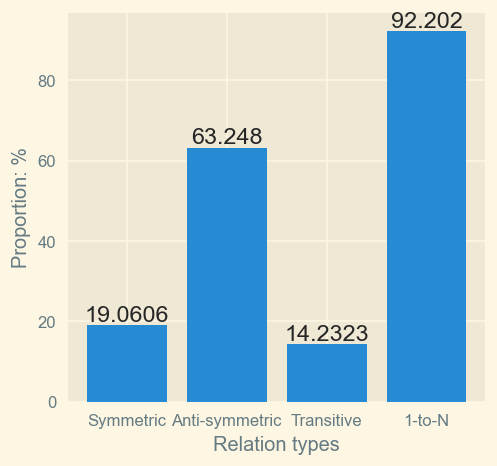

time: 435 ms (started: 2021-12-08 23:36:37 +00:00)


In [143]:
fig, ax = plt.subplots(figsize=(4,4))

# rel = ["DIS_DRUG", "DIS_PHENOTYPE", "DRUG_ACTIVATION_GENE", "DRUG_BINDACT_GENE", "DRUG_BINDING_GENE", "DRUG_BINDINH_GENE", "DRUG_CATALYSIS_GENE", "DRUG_INHIBITION_GENE", "DRUG_PHENOTYPE", "DRUG_REACTION_GENE", "GENE_ACTIVATION_GENE", "GENE_BINDING_GENE", "GENE_CATALYSIS_GENE", "GENE_DIS", "GENE_DRUG", "GENE_EXPRESSED_ANATOMY", "GENE_EXPRESSION_GENE", "GENE_GENE", "GENE_GO", "GENE_INHIBITION_GENE", "GENE_OVEREXPRESSED_ANATOMY", "GENE_PATHWAY", "GENE_PHENOTYPE", "GENE_PTMOD_GENE", "GENE_REACTION_GENE", "GENE_UNDEREXPRESSED_ANATOMY", "IS_A", "PART_OF"]
# distri = [0.1526, 0.5104, 0.2802, 0.0267, 3.8515, 0.0439, 0.5449, 0.3545, 1.9181, 0.4348, 0.5952, 5.5426, 5.9012, 0.0634, 3.8931, 31.5587, 0.0017, 16.8783, 4.3937, 0.2179, 2.8736, 2.9207, 3.4674, 0.0988, 7.5180, 2.7819, 2.8205, 0.3557]
rel_type = ["Symmetric", "Anti-symmetric", "Transitive", "1-to-N"]
rel_type_distri = [19.0606,63.2480,14.2323,92.2020]
x_pos = np.arange(len(rel_type))
width = 0.8
bar = ax.bar(x_pos - width / 2, rel_type_distri, width)
ax.set_xticks(x_pos - width / 2, labels=rel_type)
ax.set_xlabel("Relation types")
ax.set_ylabel("Proportion: %")
ax.bar_label(bar)
# for bin in bar:
#     height = bin.get_height()
#     ax.text(x=bin.get_x() + bin.get_width() / 2, y=height-10,
#         s="{}".format(height),
#         ha='center')
plt.show()
# plt.savefig("relation_quantity.png")

In [98]:
plt.rcParams['figure.dpi'] = 120

time: 544 µs (started: 2021-12-08 21:58:50 +00:00)


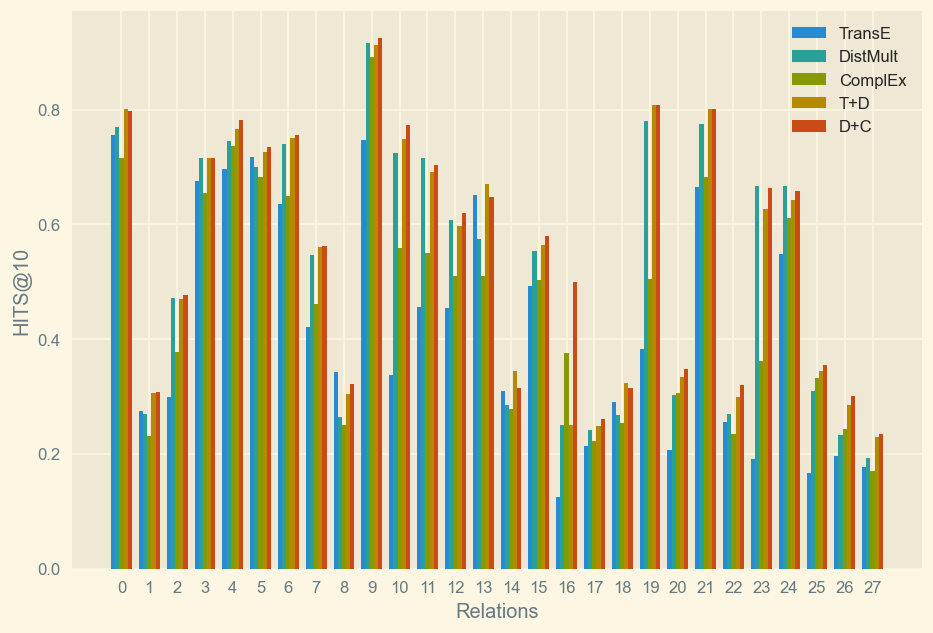

time: 710 ms (started: 2021-12-09 15:55:46 +00:00)


In [195]:
x_label = list(np.arange(28))
transe_ = [0.7557, 0.2748, 0.299, 0.6757, 0.6958, 0.7174, 0.6355, 0.4205, 0.3434, 0.747, 0.338, 0.4556, 0.4543, 0.6516, 0.3092, 0.4928, 0.125, 0.2132, 0.2905, 0.3824, 0.2074, 0.6652, 0.2548, 0.1909, 0.5487, 0.1674, 0.1963, 0.1763]
dist_ = [0.77, 0.2692, 0.4711, 0.7162, 0.7446, 0.7, 0.7405, 0.5464, 0.265, 0.9163, 0.725, 0.7162, 0.6079, 0.5742, 0.2846, 0.5541, 0.25, 0.2422, 0.268, 0.7807, 0.3024, 0.7751, 0.2691, 0.6673, 0.666, 0.3097, 0.2325, 0.1929]
cplx_ = [0.7157, 0.2313, 0.3769, 0.6554, 0.7361, 0.6826, 0.6498, 0.4616, 0.2499, 0.8913, 0.559, 0.5496, 0.5103, 0.5097, 0.2783, 0.5029, 0.375, 0.2217, 0.2534, 0.5053, 0.3061, 0.6833, 0.2355, 0.3618, 0.6108, 0.3331, 0.2434, 0.1695]
hb_td_ = [0.8014, 0.3062, 0.4703, 0.7162, 0.7656, 0.7261, 0.7504, 0.5603, 0.3039, 0.9123, 0.7489, 0.6913, 0.5969, 0.671, 0.345, 0.5644, 0.25, 0.2479, 0.3234, 0.8075, 0.3342, 0.8016, 0.2988, 0.6273, 0.643, 0.3449, 0.2848, 0.2297]
hb_dcr_ = [0.7971, 0.3045, 0.477, 0.7365, 0.7781, 0.7348, 0.754, 0.5669, 0.3167, 0.9248, 0.7682, 0.7087, 0.6226, 0.6452, 0.3179, 0.5762, 0.5, 0.2542, 0.3115, 0.803, 0.3417, 0.8028, 0.3161, 0.6655, 0.6596, 0.348, 0.2949, 0.234]
hb_dc_ = [0.7971, 0.3071, 0.4763, 0.7162, 0.7814, 0.7348, 0.7548, 0.5629, 0.3226, 0.9248, 0.7732, 0.7036, 0.6205, 0.6484, 0.3146, 0.58, 0.5, 0.2606, 0.3149, 0.8084, 0.3478, 0.8014, 0.3193, 0.6636, 0.6584, 0.3554, 0.3011, 0.2346]

x = np.arange(28)
width = 0.15

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 2, transe_, width, label='TransE')
rects2 = ax.bar(x - width, dist_, width, label='DistMult')
rects3 = ax.bar(x, cplx_, width, label='ComplEx')
rects4 = ax.bar(x + width, hb_td_, width, label='T+D')
# rects5 = ax.bar(x + width * 2, hb_dcr_, width, label='D+C+r')
rects5 = ax.bar(x + width * 2, hb_dc_, width, label='D+C')

ax.set_xlabel("Relations")
ax.set_ylabel("HITS@10")
# ax.set_title("HITS@10 ")
ax.set_xticks(x, x_label)
ax.legend()

fig.tight_layout()
plt.show()


In [193]:
# this cell is used to convert clipboard to list

copy = pd.read_clipboard(header=None)
print(copy[0].tolist())

[0.7971, 0.3071, 0.4763, 0.7162, 0.7814, 0.7348, 0.7548, 0.5629, 0.3226, 0.9248, 0.7732, 0.7036, 0.6205, 0.6484, 0.3146, 0.58, 0.5, 0.2606, 0.3149, 0.8084, 0.3478, 0.8014, 0.3193, 0.6636, 0.6584, 0.3554, 0.3011, 0.2346]
time: 109 ms (started: 2021-12-09 15:53:37 +00:00)
